## Transcriptome annotation on AWS

This notebook execute our workflow using AWS. We explore different [machine types]( https://aws.amazon.com/ec2/instance-types/), from the second generation M5D and M5DN instances that feature 2nd generation Intel Xeon Scalable Processors (Cascade Lake) with a sustained all-core Turbo CPU frequency of 3.1 GHz. M5DN is ideal for network intensive applications because they include a custom Nitro card and Elastic Network Adapter (ENA) device to deliver up to 100 Gbps of network throughput to a single instance. Three number of CPUs for each machine type: 16, 32, and 64 were tested. We will call `configuration` to the combination of `MACHINE_TYPE/CPU`

The input data, transcriptome in FASTA file, is partitioned in the [01 - Data Partitioning.ipynb]( 01%20-%20Data%20Partitioning.ipynb). 20 FASTA files are created for each query size and are uploaded to a S3 storage bucket with prefixes: `nopal-2000-<UUID>` for input data and `nopal-results-2000-<UUID>` for the results files (2000 is for the query size processed and will be 2000, 6000 and 10000).

This notebook will create an organizational structure for storing the jobs descriptions and logs files. It includes directories following the convention: `QUERY_SIZE/MACHINE_TYPE/CPU`. See next directory tree for more information:

```bash
└── ./PRJNA320545/
      ├── 10000
      │   ├── m5d
      │   │   ├── 64
      │   │   ├── 32
      │   │   └── 16
      │   ├── m5dn
      │   │   ├── 64
      │   │   ├── 32
      │   │   └── 16
      │   └── fasta
      ├── 6000
      │   ├── m5d
      │   │   ├── 64
      │   │   ├── 32
      │   │   └── 16
      │   ├── m5dn
      │   │   ├── 64
      │   │   ├── 32
      │   │   └── 16
      │   └── fasta
      └── 2000
          ├── m5d
          │   ├── 64
          │   ├── 32
          │   └── 16
          ├── m5dn
          │   ├── 64
          │   ├── 32
          │   └── 16
          └── fasta

30 directories
```

After completion, each configuration, `QUERY_SIZE/MACHINE_TYPE/CPU`, will include 40 files, two per job with extensions: 

 * _job.json.gz: Json with the job description returned with **aws batch describe-jobs**
 * _log.json.gz: Json with the job logs returned with **aws logs get-log-events --log-group-name /aws/batch/job**

```bash
└── 2000
    ├── m5d
        ├── 64
        ├── 1bb53a49-cdb3-4434-8839-0263a8f07ea4_job.json.gz
        ├── 1bb53a49-cdb3-4434-8839-0263a8f07ea4_log.json.gz
        ├── 1ce4660e-c0e7-4cc7-b06d-50bdcfaba5c6_job.json.gz
        ├── 1ce4660e-c0e7-4cc7-b06d-50bdcfaba5c6_log.json.gz
        ├── 2a375778-8a9f-449a-98bc-9904571d774f_job.json.gz
        ├── 2a375778-8a9f-449a-98bc-9904571d774f_log.json.gz
        ├── 39219810-ae2d-4f02-93dc-42a4523838e1_job.json.gz
        ├── 39219810-ae2d-4f02-93dc-42a4523838e1_log.json.gz
        ├── 39ea074e-00c0-4eaa-b9ba-a0dbaca093f0_job.json.gz
        ├── 39ea074e-00c0-4eaa-b9ba-a0dbaca093f0_log.json.gz
        ├── 409c9a06-70fa-42f5-9ccd-5cfe150139cf_job.json.gz
        ├── 409c9a06-70fa-42f5-9ccd-5cfe150139cf_log.json.gz
        ├── 5774c8b0-5c43-4ed6-9a09-92f0b9b41683_job.json.gz
        ├── 5774c8b0-5c43-4ed6-9a09-92f0b9b41683_log.json.gz
        ├── 72f396dd-431a-4214-af97-55bdfc91f0ae_job.json.gz
        ├── 72f396dd-431a-4214-af97-55bdfc91f0ae_log.json.gz
        ├── 7333d168-9def-4526-8a7f-1598ac6309dc_job.json.gz
        ├── 7333d168-9def-4526-8a7f-1598ac6309dc_log.json.gz
        ├── 87b38638-de1d-4b20-945d-851f592a7575_job.json.gz
        ├── 87b38638-de1d-4b20-945d-851f592a7575_log.json.gz
        ├── 908dbc68-2d40-407d-abe3-67fddeb23d07_job.json.gz
        ├── 908dbc68-2d40-407d-abe3-67fddeb23d07_log.json.gz
        ├── 93b5459b-b2c4-409d-9dd4-e1db8f9b70fb_job.json.gz
        ├── 93b5459b-b2c4-409d-9dd4-e1db8f9b70fb_log.json.gz
        ├── 97093d57-5cce-4962-a6f7-040eddabc4fd_job.json.gz
        ├── 97093d57-5cce-4962-a6f7-040eddabc4fd_log.json.gz
        ├── a2421aeb-d5e8-40ad-a353-af6c0adc93c6_job.json.gz
        ├── a2421aeb-d5e8-40ad-a353-af6c0adc93c6_log.json.gz
        ├── cf25552a-a29c-4818-ba67-1002ee96533b_job.json.gz
        ├── cf25552a-a29c-4818-ba67-1002ee96533b_log.json.gz
        ├── d278f30f-7437-4290-b892-ef17e8f403dc_job.json.gz
        ├── d278f30f-7437-4290-b892-ef17e8f403dc_log.json.gz
        ├── d34e4005-73a2-4b6e-9830-91d9fcf77795_job.json.gz
        ├── d34e4005-73a2-4b6e-9830-91d9fcf77795_log.json.gz
        ├── e285f19b-ad47-41bc-a90e-0776ffcabe4a_job.json.gz
        ├── e285f19b-ad47-41bc-a90e-0776ffcabe4a_log.json.gz
        ├── f201e0b8-20a2-4cbc-9233-baaf661b27c6_job.json.gz
        ├── f201e0b8-20a2-4cbc-9233-baaf661b27c6_log.json.gz
        ├── fd230900-874c-40ab-b2cd-f69ecd9597cb_job.json.gz
        └── fd230900-874c-40ab-b2cd-f69ecd9597cb_log.json.gz

0 directories, 40 files
```

### AWS Configuration

### AWS Access Key

This notebook assumes that you created a AWS access key as described [here](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_credentials_access-keys.html#Using_CreateAccessKey)

To configure the AWS-cli execute **aws configure**

```bash
$ aws configure
AWS Access Key ID [None]: ................W7MTD
AWS Secret Access Key [None]: ....................4dypPikIFg
Default region name [None]: us-east1
Default output format [None]: json
$
```

### Configuration created in this Notebook 

This notebook will use the [AWS Batch System](https://aws.amazon.com/batch/) to create 6 [compute environments](https://docs.aws.amazon.com/batch/latest/userguide/compute_environments.html), one for each `configuration` of `MACHINE_TYPE/CPU`. Then, 6 [job queues](https://docs.aws.amazon.com/batch/latest/userguide/job_queues.html) and 6 [job definitions](https://docs.aws.amazon.com/batch/latest/userguide/job_definitions.html) will be created for each compute environment.  

Automatically, AWS will create a [Amazon Elastic Container Service](https://aws.amazon.com/ecs/) (ECs) for each compute envionment associated to 6 [Auto Scalling groups](https://docs.aws.amazon.com/autoscaling/ec2/userguide/AutoScalingGroup.html)

The notebook creates a complete Amazon Virtual Private Cloud (VPC), including ACL, routes and subnets that will be used for all resources created under this setup. 

Then, a custom [Amazon Machine Image](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/AMIs.html), which is public available with ID: **ami-0dac0383cac1dc96e** in the **us-east-1** zone, will be used by the ECs for launching on-demand instances. However, if you are working in a different zone than the **us-east-1** you should copy the AMI to your working zone following this [tutorial](https://scrapoxy.readthedocs.io/en/master/standard/providers/awsec2/copy_ami_to_region/). The final AMI ID should be defined in the third cell.

### Deleting resources

After completion (last cell of this notebook), all AWS Batch compute environments, queues and job definitions will be deleted.

#### Delete VPC 

User should go to the AWS console and delete the created [VPV](https://console.aws.amazon.com/vpc/). 

#### Copying and deleting S3 buckets

S3 bucktes can be accessed and deleted from the [AWS S3 console](https://s3.console.aws.amazon.com/s3/) 

### Set AWS tags for resources

We defined two json files for defining Tags for all the AWS resources created by this notebook. This help to control cost and identify resources. Edit these files and chage the tags accordingly to your needs.

 1. [aws-tags-s3.json](/edit/config/aws/aws-tags-s3.json) Tags used by S3
 2. [aws-tags.json](/edit/config/aws/aws-tags.json) Tags used by all other resources


### Loading packages from config/init.py

In [1]:
%run ../config/init.py

### Testing AWS-cli configuration

In [2]:
access_key = !aws configure get aws_access_key_id
secret_access_key = !aws configure get aws_secret_access_key
if access_key and secret_access_key:
    print('Using access_key: ........{}'.format(access_key[0][10:]))
else:
    print('Please, configure AWS-cli before running this notebook')
    print('Open a Terminal and run: aws configure')

Using access_key: ........XVULYDAZGO


### Defining variables

Edit AWS zone and region variable accordingly to your geographical location.

In [3]:
USE_SPOT = False
REGION = 'us-east-1'
ZONE = 'us-east-1a'
AMI = 'ami-0dac0383cac1dc96e'
!aws configure set region {REGION}

### Defining global Tags for identifying resources

Associate AWS Tags with each resource created by this notebook helps to compile total cost used by AWS.
The notebook will use, if exists, a file in the **CONFIG/aws** folder named: **aws-tags.json**

In [4]:
TAGFILE_S3 = None
TAGFILE = None
TAGDIR = None
if os.path.exists(os.path.join(CONFIG, "aws", "aws-tags-s3.json")):
    TAGFILE_S3 = os.path.join(CONFIG, "aws", "aws-tags-s3.json")
if os.path.exists(os.path.join(CONFIG, "aws", "aws-tags.json")):
    TAGFILE = os.path.join(CONFIG, "aws", "aws-tags.json")
    with open(TAGFILE) as fin:
        TAGDICT = json.loads(fin.read())
    PROJECT = None
    for k in TAGDICT['Tags']:
        if k['Key'] == 'Project':
            PROJECT = k['Value']
    if PROJECT:
        print("Using project tag: {}".format(PROJECT))

Using project tag: cbb-research-dl


### AWS machine types

| Instance Size | vCPU | Memory (GiB) | Instance Storage (GiB) | Network Bandwidth (Gbps) | EBS Bandwidth (Mbps) |  \$/Hour | SPOT \$/Hour |
|---------|----------|----------|-------------|---------------|---------------|-----------|-----------|
| m5d.4xlarge | 16 | 64 | 2 x 300 NVMe SSD | Up to 10 | 4,750 | 0.904 | 0.1783 |
| m5d.8xlarge | 32 | 128 | 2 x 600 NVMe SSD | 10 | 6,800 | 1.808 | 0.3233 |
| m5d.16xlarge | 64 | 256 | 4 x 600 NVMe SSD | 20 | 13,600 | 3.616 | 0.6941 |
| m5dn.4xlarge | 16 | 64 | 2 x 300 NVMe SSD | Up to 25 | 4,750 | 1.088 | 0.2058 |
| m5dn.8xlarge | 32 | 128 | 2 x 600 NVMe SSD | 25 | 6,800| 2.176 | 0.3193 |
| m5dn.16xlarge | 64 | 256 | 4 x 600 NVMe SSD | 75 | 13,600 | 4.352 | 0.6551 |


In [5]:
QUERY_SIZES = [2000, 6000, 10000]

MACHINE_TYPES = ['m5d', 'm5dn']
CPUs = [
    {
        'name':'4xlarge',
        'CPUs': 16,
        'memory': 64 * 1000 - 5000
    }, 
    {
        'name':'8xlarge',
        'CPUs': 32,
        'memory': 128 * 1000 - 5000
    }, 
    {
        'name':'16xlarge',
        'CPUs': 64,
        'memory': 256 * 1000 - 5000
    }]

# Prices from 03/04/2020
# EC2 PRICE
EC2_PRICE = {
    'm5d':{
        16: 0.904,
        32: 1.808,
        64: 3.616
    },
    'm5dn':{
        16: 1.088,
        32: 2.176,
        64: 4.352
    }    
}
#SPOT PRICE
SPOT_PRICE = {
    'm5d':{
        16: 0.1783,
        32: 0.3233,
        64: 0.6941
    },
    'm5dn':{
        16: 0.2058,
        32: 0.3193,
        64: 0.6551
    }    
}


In [6]:
result_dir = os.path.join(RESULTS, DATASET)
if not os.path.exists(result_dir):
    os.mkdir(result_dir) 
os.chdir(result_dir)
print('Using as output directory: {}'.format(result_dir))

Using as output directory: /panfs/pan1.be-md.ncbi.nlm.nih.gov/alt_splicing/cloud-transcriptome-annotation/results/PRJNA320545


### Create or retrieve AWS S3 storage bucket

In [7]:
bucket_list = !aws s3 ls | awk '{print $3}'
buckets = {}
for q in QUERY_SIZES:
    prefix = 'nopal-' + str(q) + '-'
    suffix = None
    for l in bucket_list:
        if prefix in l:
            suffix = l.replace('nopal-' + str(q) + '-','')
            break
    if suffix:
        buckets[q] = suffix    

for q in QUERY_SIZES:
    if q not in buckets:
        suffix = str(uuid.uuid4())
        inbucket = 'nopal-' + str(q) + '-' + suffix
        outbucket = 'nopal-results-' + str(q) + '-' + suffix
        buckets[q] = suffix 
        
        !aws s3 mb s3://{inbucket} --region {REGION}          
        !aws s3 mb s3://{outbucket} --region {REGION}
        if TAGFILE_S3:
            !aws s3api put-bucket-tagging --bucket {inbucket} --tagging file://{TAGFILE_S3} 
            !aws s3api put-bucket-tagging --bucket {outbucket} --tagging file://{TAGFILE_S3} 
        !aws s3 cp {q}/fasta/ s3://{inbucket}/ --recursive
        
for q in buckets:
    print('Query size: {0}\n\tin-bucket: nopal-{0}-{1}\n\tout-bucket: nopal-results{0}-{1}'.format(q, buckets[q]))

Query size: 2000
	in-bucket: nopal-2000-a3f0609c-a795-4750-b46b-917fec2f53ab
	out-bucket: nopal-results2000-a3f0609c-a795-4750-b46b-917fec2f53ab
Query size: 6000
	in-bucket: nopal-6000-3ab7042a-20ff-4c77-8d33-b2ef677bd185
	out-bucket: nopal-results6000-3ab7042a-20ff-4c77-8d33-b2ef677bd185
Query size: 10000
	in-bucket: nopal-10000-d801420a-be79-44a2-85f3-171eb754bd79
	out-bucket: nopal-results10000-d801420a-be79-44a2-85f3-171eb754bd79


## Creating AWS EC2 components

### Creating an Internet gateway.

https://docs.aws.amazon.com/cli/latest/reference/ec2/create-internet-gateway.html

In [8]:
igw = !aws ec2 describe-internet-gateways --filters Name=tag:Project,Values={PROJECT}
igw = json.loads(''.join(igw))   
if 'InternetGateways' in igw and len(igw['InternetGateways']) > 0:
    igw = igw['InternetGateways'][0]
    print('Using Internet Gateway: {}'.format(igw['InternetGatewayId']))
else:
    igw = !aws ec2 create-internet-gateway
    igw = json.loads(''.join(igw))
    if 'InternetGateway' in igw and 'InternetGatewayId' in igw['InternetGateway']:
        igw = igw['InternetGateway']
        print('Created Internet Gateway: {}'.format(igw['InternetGatewayId']))
        if TAGFILE:
            igw_id = igw['InternetGatewayId']
            !aws ec2 create-tags --resources {igw_id} --cli-input-json file://{TAGFILE}

Using Internet Gateway: igw-00916243d902a86ed


### Creating the Amazon Virtual Private Cloud  (VPC) and all its componets

* VPC: https://docs.aws.amazon.com/cli/latest/reference/ec2/create-vpc.html
* ACL: https://docs.aws.amazon.com/cli/latest/reference/ec2/create-network-acl.html
* Route Table: https://docs.aws.amazon.com/cli/latest/reference/ec2/create-route-table.html
* Subnet: https://docs.aws.amazon.com/cli/latest/reference/ec2/create-subnet.html

In [9]:
vpc = !aws ec2 describe-vpcs --filters Name=tag:Project,Values={PROJECT}
vpc = json.loads(''.join(vpc))
if 'Vpcs' in vpc and len(vpc['Vpcs']) > 0:
    vpc = vpc['Vpcs'][0]
    vpc_id = vpc['VpcId']
    igw_id = igw['InternetGatewayId']
    print('Using VPC: {}'.format(vpc['VpcId']))
    subnet = !aws ec2 describe-subnets --filters "Name=vpc-id,Values={vpc_id}"
    subnet = json.loads(''.join(subnet))
    if 'Subnets' in subnet:
        subnet = subnet['Subnets'][0]   
        subnet_id = subnet['SubnetId']

        print('Subnet {} attached to VPC {}'.format(subnet_id, vpc_id)) 
        
    route = !aws ec2 describe-route-tables  --filters "Name=vpc-id,Values={vpc_id}"
    route = json.loads(''.join(route))
    if 'RouteTables' in route and len(route['RouteTables']) == 1:
        route = route['RouteTables'][0]
        route_id = route['RouteTableId']
    
    acl = !aws ec2 describe-network-acls --filters Name=vpc-id,Values={vpc_id}
    acl = json.loads(''.join(acl))
    if 'NetworkAcls' in acl and len(acl['NetworkAcls']) == 1:
        acl = acl['NetworkAcls'][0]
        acl_id = acl['NetworkAclId'] 
    
else:
    print('No VPC, creating it ..... ')
    vpc = !aws ec2 create-vpc --cidr-block 10.0.0.0/16 --amazon-provided-ipv6-cidr-block 
    vpc = json.loads(''.join(vpc))
    if 'Vpc' in vpc:
        vpc = vpc['Vpc']
        vpc_id = vpc['VpcId']
        print('Created VPC: {}'.format(vpc_id))
        # adding Tags if file exists
        if TAGFILE:        
            !aws ec2 create-tags --resources {vpc_id} --cli-input-json file://{TAGFILE}

        # Attaching igw
        igw_id = igw['InternetGatewayId']
        print('Attaching IGW {} to the VPC: {}'.format(igw_id, vpc_id))
        !aws ec2 attach-internet-gateway --internet-gateway-id {igw_id} --vpc-id {vpc_id}

        # Retrieving created ACL
        acl = !aws ec2 describe-network-acls --filters Name=vpc-id,Values={vpc_id}
        acl = json.loads(''.join(acl))
        if 'NetworkAcls' in acl and len(acl['NetworkAcls']) == 1:
            acl = acl['NetworkAcls'][0]
            acl_id = acl['NetworkAclId']
            # adding Tags if file exists
            if TAGFILE:                
                print('Tagging ACL {}'.format(acl_id))
                !aws ec2 create-tags --resources {acl_id} --cli-input-json file://{TAGFILE}

        # Retrieving created routes
        route = !aws ec2 describe-route-tables --filters Name=vpc-id,Values={vpc_id}
        route = json.loads(''.join(route))
        if 'RouteTables' in route and len(route['RouteTables']) == 1:
            route = route['RouteTables'][0]
            route_id = route['RouteTableId']
                
            route_igw = !aws ec2 create-route --route-table-id {route_id} --destination-cidr-block 0.0.0.0/0 --gateway-id {igw_id}
            route_igw = json.loads(''.join(route_igw))
            if 'Return' in route_igw and route_igw['Return']:
                print('IGW {} attached to route {}'.format(igw_id, route_id))
            
            # adding Tags if file exists
            if TAGFILE:
                print('Tagging Route {}'.format(route_id))
                !aws ec2 create-tags --resources {route_id} --cli-input-json file://{TAGFILE}

        # Creating Subnets
        subnet = !aws ec2 create-subnet --vpc-id {vpc_id} --cidr-block 10.0.0.0/16 --availability-zone {ZONE}
        subnet = json.loads(''.join(subnet))
        if 'Subnet' in subnet:
            subnet = subnet['Subnet']   
            subnet_id = subnet['SubnetId']
            
            print('Subnet {} attached to VPC {}'.format(subnet_id, vpc_id))
            !aws ec2 modify-subnet-attribute --subnet-id {subnet_id} --map-public-ip-on-launch
            print('Public IPs enable on subnet {}'.format(subnet_id))
            
            # adding Tags if file exists
            if TAGFILE:
                print('Tagging subnet {}'.format(subnet_id))
                !aws ec2 create-tags --resources {subnet_id} --cli-input-json file://{TAGFILE}

Using VPC: vpc-0c0a9fdd87030446d
Subnet subnet-0882777bc17300040 attached to VPC vpc-0c0a9fdd87030446d


### Creating AWS Batch 
#### Getting AWSBatchServiceRole information

 * https://docs.aws.amazon.com/cli/latest/reference/iam/list-roles.html

In [10]:
try:
    awsBatchRole = None
    spotFleetRole = None
    output = !aws iam list-roles
    roles = json.loads(''.join(output))
    if 'Roles' in roles:
        for r in roles['Roles']:
            if 'AWSBatchServiceRole' == r['RoleName']:
                awsBatchRole = r
                print('Using AWSBatchServiceRole: {}'.format(awsBatchRole['Arn']))
            elif 'AmazonEC2SpotFleetRole' == r['RoleName']:
                spotFleetRole = r
                print('Using AmazonEC2SpotFleetRole: {}'.format(spotFleetRole['Arn']))
    if not awsBatchRole:
        print('Error: AWSBatchServiceRole not available in your account.')
        print('Please, creates the AWSBatchServiceRole before continue as it is described:')
        print('https://docs.aws.amazon.com/batch/latest/userguide/service_IAM_role.html')
    if not spotFleetRole and USE_SPOT:
        print('Error: AmazonEC2SpotFleetRole not available in your account.')
        print('Please, creates the AmazonEC2SpotFleetRole before continue as it is described:')
        print('https://docs.aws.amazon.com/batch/latest/userguide/spot_fleet_IAM_role.html')
except:
    print('Error: {}'.format(output))

Using AmazonEC2SpotFleetRole: arn:aws:iam::036922703339:role/AmazonEC2SpotFleetRole
Using AWSBatchServiceRole: arn:aws:iam::036922703339:role/AWSBatchServiceRole


### Creation of the AWS Batch System    

#### Creating a security group
 
 * https://docs.aws.amazon.com/cli/latest/reference/ec2/create-security-group.html
 * https://docs.aws.amazon.com/cli/latest/reference/ec2/describe-security-groups.html

In [11]:
sg = !aws ec2 describe-security-groups --filters Name=tag:Project,Values={PROJECT}
sg = json.loads(''.join(sg))
if 'SecurityGroups' in sg and len(sg['SecurityGroups']) >= 1:
    sg = sg['SecurityGroups'][0]
    sg_id = sg['GroupId']
    print('Using sg {}'.format(sg_id))
else:
    sg_name = PROJECT
    sg_descr = 'Security Group for project: ' + PROJECT
    sg = !aws ec2 create-security-group --group-name {sg_name}  --description "{sg_descr}" --vpc-id {vpc_id}
    sg = json.loads(''.join(sg))
    if 'GroupId' in sg:
        sg_id = sg['GroupId']
        print('SG {} created'.format(sg_id))
        
        print('Adding SSH inbound to the sg {}'.format(sg_id))
        !aws ec2 authorize-security-group-ingress --group-id {sg_id} --protocol tcp --port 22 --cidr 0.0.0.0/0
        
        # adding Tags if file exists
        if TAGFILE:
            print('Tagging sg {}'.format(sg_id))
            !aws ec2 create-tags --resources {sg_id} --cli-input-json file://{TAGFILE}

Using sg sg-02e8ee80022548d68


#### Creating Compuational Environment

 * https://docs.aws.amazon.com/cli/latest/reference/batch/create-compute-environment.html
 * https://docs.aws.amazon.com/cli/latest/reference/batch/describe-compute-environments.html

In [12]:
for m in MACHINE_TYPES:  
    for c in CPUs:
        instance_type = '{}.{}'.format(m,c['name'])
        comp_env_name = '{}_{}_managed'.format(m,c['name'])
        comp_env = None
        try:
            output = !aws batch describe-compute-environments --compute-environments {comp_env_name}
            comp_env = json.loads(''.join(output))
            if 'computeEnvironments' in comp_env and len(comp_env['computeEnvironments']) == 1:
                comp_env = comp_env['computeEnvironments'][0]
                print('Using Computational env: {}'.format(comp_env['computeEnvironmentName']))
            else:
                comp_env = None
        except:
            print('Error: {}'.format(output))
        if not comp_env:
            try:
                print('Computational env: {} does not exist. Creating it ...'.format(comp_env_name))
                create_comp_env_dict(comp_env_name, c['CPUs'], instance_type, AMI, subnet_id, sg_id, awsBatchRole['Arn'], spotFleetRole['Arn'], USE_SPOT, TAGDICT['Tags'], 'aws-nopal')
                comp_env_json = os.path.join(CONFIG, "aws", 'compute-env-{}.json'.format(comp_env_name))            
                output = !aws batch create-compute-environment --cli-input-json file://{comp_env_json}
                comp_env = json.loads(''.join(output))
                print('Computational env: {} created'.format(comp_env['computeEnvironmentName']))                             
            except:
                print('Error: {}'.format(output))

Using Computational env: m5d_4xlarge_managed
Using Computational env: m5d_8xlarge_managed
Using Computational env: m5d_16xlarge_managed
Using Computational env: m5dn_4xlarge_managed
Using Computational env: m5dn_8xlarge_managed
Using Computational env: m5dn_16xlarge_managed


#### Creating Job queue

 * https://docs.aws.amazon.com/cli/latest/reference/batch/create-job-queue.html
 * https://docs.aws.amazon.com/cli/latest/reference/batch/describe-job-queues.html

In [13]:
for m in MACHINE_TYPES:  
    for c in CPUs:
        queue_name = '{}_{}_queue'.format(m,c['name'])
        comp_env_name = '{}_{}_managed'.format(m,c['name'])
        queue = None
        try:
            output = !aws batch describe-job-queues --job-queues {queue_name}
            queue = json.loads(''.join(output))
            if 'jobQueues' in queue and len(queue['jobQueues']) == 1:
                queue = queue['jobQueues'][0]
                print('Using queue: {}'.format(queue['jobQueueName']))
            else:
                queue = None

        except:
            print('Error: {}'.format(output))
        if not queue:
            try:
                print('Queue: {} does not exist. Creating it ...'.format(queue_name))
                queue_template_json = os.path.join(CONFIG, "aws", 'queue-template.json')  
                queue_json = os.path.join(CONFIG, "aws", 'queue-{}.json'.format(queue_name))   
                with open(queue_template_json) as fin:
                    with open(queue_json, "w") as fout:
                        queue = json.load(fin)
                        queue['jobQueueName'] = queue_name
                        queue['computeEnvironmentOrder'][0]['computeEnvironment'] = comp_env_name
                        fout.write(json.dumps(queue, indent=4))
                output = !aws batch create-job-queue --cli-input-json file://{queue_json}
                queue = json.loads(''.join(output))
                print('Queue: {} created'.format(queue['jobQueueName']))                             
            except:
                print('Error: {}'.format(output))

Using queue: m5d_4xlarge_queue
Using queue: m5d_8xlarge_queue
Using queue: m5d_16xlarge_queue
Using queue: m5dn_4xlarge_queue
Using queue: m5dn_8xlarge_queue
Using queue: m5dn_16xlarge_queue


### Registering jobs

 * https://docs.aws.amazon.com/cli/latest/reference/batch/register-job-definition.html
 * https://docs.aws.amazon.com/cli/latest/reference/batch/describe-job-definitions.html

In [14]:
for m in MACHINE_TYPES: 
    for c in CPUs:
        job_def_name = '{}_{}'.format(m,c['name'])
        try:
            output = !aws batch describe-job-definitions --job-definition-name {job_def_name}
            job = json.loads(''.join(output))
            if 'jobDefinitions' in job and len(job['jobDefinitions']) >= 1:
                job = job['jobDefinitions'][0]
                print('Using job definition: {}'.format(job['jobDefinitionName']))
            else:
                job = None

        except:
            print('Error: {}'.format(output))
        if not job:       
            try:
                print('Job: {} does not exist. Creating it ...'.format(job_def_name))
                job_template_json = os.path.join(CONFIG, "aws", 'job-definition-template.json')  
                jon_json = os.path.join(CONFIG, "aws", 'job-definition-{}.json'.format(job_def_name))   
                with open(job_template_json) as fin:
                    with open(jon_json, "w") as fout:
                        job = json.load(fin)
                        job['jobDefinitionName'] = job_def_name
                        job['containerProperties']['vcpus'] = c['CPUs']
                        job['containerProperties']['memory'] = c['memory']
                        job['containerProperties']['environment'].append({'name': 'CPUs' , 'value': str(c['CPUs'])})
                        job['containerProperties']['environment'].append({'name': 'MACHINE_TYPE' , 'value': '{}_{}'.format(m,c['name'])})
                        fout.write(json.dumps(job, indent=4))
                    output = !aws batch register-job-definition --cli-input-json file://{jon_json}
                    job = json.loads(''.join(output))
                print('Job: {} created'.format(job['jobDefinitionName']))   
            except:
                print('Error: {}'.format(output))

Using job definition: m5d_4xlarge
Using job definition: m5d_8xlarge
Using job definition: m5d_16xlarge
Using job definition: m5dn_4xlarge
Using job definition: m5dn_8xlarge
Using job definition: m5dn_16xlarge


### Submitting the jobs to the AWS Batch

 * https://docs.aws.amazon.com/cli/latest/reference/batch/submit-job.html
 
Once jobs are submitted you can view the queues in the AWS console:

 * https://console.aws.amazon.com/batch/
 
This code check if the job id file from AWS exists. If the not exists the job will be marked to be submitted again.


In [7]:
bar_length = 20
jobs = {}
jobs_to_submit = 0
for q in QUERY_SIZES:
    jobs[q] = {}
    q_dir = os.path.join(result_dir, str(q))
    for m in MACHINE_TYPES:
        jobs[q][m] = {}
        for c in CPUs:
            jobs[q][m][c['CPUs']] = {}
            instace_dir = os.path.join(q_dir, m, str(c['CPUs']))
            if not os.path.exists(instace_dir):
                os.makedirs(instace_dir)
            os.chdir(instace_dir)
            for i in range(1,21):
                if os.path.exists('{}.id'.format(i)):                    
                    jobs[q][m][c['CPUs']][i] = {'completed': True}
                else:
                    jobs_to_submit += 1
                    jobs[q][m][c['CPUs']][i] = {'completed': False}
print('{} jobs to be submitted'.format(jobs_to_submit))

0 jobs to be submitted


### Submitting jobs to AWS Batch

Skip the next cell if the jobs were already submitted and the **operations.tsv** file is in each output directory.
The notebook will use the job ids in the **operations.tsv** to download the logs and check the job status.

In [44]:
for m in MACHINE_TYPES: 
    for c in CPUs:
        job_def_name = '{}_{}'.format(m,c['name'])
        for q in QUERY_SIZES: 
            q_dir = os.path.join(result_dir, str(q))
            instace_dir = os.path.join(q_dir, m, str(c['CPUs']))
            os.chdir(instace_dir)
            inbucket = 'nopal-' + str(q) + '-' + buckets[q]
            outbucket = 'nopal-results-' + str(q) + '-' + buckets[q]
            data = []
            submitted = 0
            for i in range(1,21):
                if i in jobs[q][m][c['CPUs']] and not jobs[q][m][c['CPUs']][i]['completed']:
                    submitted += 1
                    sample = '{}_{}'.format(q, i)
                    job_name = '{}_{}'.format(sample, job_def_name)             
                    cmd = 'aws batch submit-job --job-name {} '.format(job_name)
                    cmd += '--job-queue {}_queue '.format(job_def_name)
                    cmd += '--job-definition {} '.format(job_def_name)
                    cmd += '--container-overrides \'environment=['
                    cmd += '{name=AWS_ACCESS_KEY_ID,value=' + access_key[0] + '},'
                    cmd += '{name=AWS_SECRET_ACCESS_KEY,value=' + secret_access_key[0] + '},'
                    cmd += '{name=SAMPLE,value=' + sample + '},'
                    cmd += '{name=INBUCKET,value=' + inbucket + '},'
                    cmd += '{name=OUTBUCKET,value=' + outbucket + '}]\''

                    output = !{cmd}
                    job_id = json.loads(''.join(output))
                    with open('{}.id'.format(i), 'w') as fout:
                        fout.write(job_id['jobId'])
                progress = i * 100/20
                text = "{0:25s} [{1}] {2:3.1f}% jobs submitted {3:3d}".format(job_name, "#" * i + "-" * (bar_length - i), progress, submitted)
                print(text, end='\r')   
            print()

10000_20_m5dn_16xlarge    [####################] 100.0% jobs submitted   0
10000_20_m5dn_16xlarge    [####################] 100.0% jobs submitted   0
10000_20_m5dn_16xlarge    [####################] 100.0% jobs submitted   0
10000_20_m5dn_16xlarge    [####################] 100.0% jobs submitted   0
10000_20_m5dn_16xlarge    [####################] 100.0% jobs submitted   0
10000_20_m5dn_16xlarge    [####################] 100.0% jobs submitted   0
10000_20_m5dn_16xlarge    [####################] 100.0% jobs submitted   0
10000_20_m5dn_16xlarge    [####################] 100.0% jobs submitted   0
10000_20_m5dn_16xlarge    [####################] 100.0% jobs submitted   0
10000_20_m5dn_16xlarge    [####################] 100.0% jobs submitted   0
10000_20_m5dn_16xlarge    [####################] 100.0% jobs submitted   0
10000_20_m5dn_16xlarge    [####################] 100.0% jobs submitted   0
10000_20_m5dn_16xlarge    [####################] 100.0% jobs submitted   0
10000_20_m5dn_16xlarge   

### Retrieving Job description and logs

 * https://docs.aws.amazon.com/cli/latest/reference/batch/describe-jobs.html
 * https://docs.aws.amazon.com/cli/latest/reference/logs/get-log-events.html
 
Here we check the AWS logs and mark jobs as completed, failed or not completed. You can run the  

In [8]:
total = 0
done = 0
errors = []
total_no_completed = 0
for q in QUERY_SIZES:
    if q not in jobs:
        jobs[q] = {}
    q_dir = os.path.join(result_dir, str(q))
    for m in MACHINE_TYPES:    
        if m not in jobs[q]:
            jobs[q][m] = {}
        for c in CPUs:    
            instace_dir = os.path.join(q_dir, m, str(c['CPUs']))
            job_def_name = '{}_{}'.format(m,c['name'])            
            os.chdir(instace_dir)   
            
            if c['CPUs'] not in jobs[q][m]:
                jobs[q][m][c['CPUs']] = {}
            
            completed = 0
            failed = 0
            no_completed = 0

            for i in range(1,21):
                if os.path.exists('{}.id'.format(i)):
                    mark_to_delete = False
                    with open('{}.id'.format(i)) as fin:
                        sample = '{}_{}'.format(q, i)
                        job_name = '{}_{}'.format(sample, job_def_name) 
                        job_id = fin.read()

                        # The jobs ids loaded from the operation file are used to download the logs from AWS
                        # The logs are check to see if they completed without any error. 
                        total += 1 
                        
                        job_file = '{}_job.json.gz'.format(i)
                        log_file = '{}_log.json.gz'.format(i)

                        if os.path.exists(job_file):
                            try:
                                with gzip.GzipFile(job_file, 'r') as fin:  
                                    job = json.loads(fin.read().decode('utf-8'))
                                with gzip.GzipFile(log_file, 'r') as fin:  
                                    log = json.loads(fin.read().decode('utf-8'))
                                    if aws_log_completed(log['events']):
                                        completed += 1
                                        done += 1
                                        jobs[q][m][c['CPUs']][job_name] = {}
                                        jobs[q][m][c['CPUs']][job_name]['job'] = job
                                        jobs[q][m][c['CPUs']][job_name]['log'] = log
                                    else:
                                        failed += 1
                                        mark_to_delete = True
                            except:
                                failed += 1
                                mark_to_delete = True
                                

                        else:
                            output = !aws batch describe-jobs --jobs {job_id}
                            l = json.loads(''.join(output))
                            if 'SUCCEEDED' == l['jobs'][0]['status']:
                                logStreamName = l['jobs'][0]['container']['logStreamName']
                                output = !aws logs get-log-events --log-group-name /aws/batch/job --log-stream-name {logStreamName}
                                log = json.loads(''.join(output))
                                if aws_log_completed(log['events']):
                                    completed += 1
                                    done += 1
                                    jobs[q][m][c['CPUs']][job_name] = {}
                                    jobs[q][m][c['CPUs']][job_name]['job'] = l
                                    with gzip.GzipFile(job_file, 'w') as fout:
                                        fout.write(json.dumps(l, indent=2).encode('utf-8'))
                                    jobs[q][m][c['CPUs']][job_name]['log'] = log
                                    with gzip.GzipFile(log_file, 'w') as fout:
                                        fout.write(json.dumps(log, indent=2).encode('utf-8'))
                                else:
                                    mark_to_delete = True
                                    failed += 1

                            elif 'FAILED' == l['jobs'][0]['status']:
                                mark_to_delete = True
                                failed += 1
                            else:
                                no_completed += 1                        
                    if mark_to_delete:
                        if os.path.exists(job_file):
                            os.remove(job_file)
                        if os.path.exists(log_file):
                            os.remove(log_file)
                        os.remove('{}.id'.format(i))
                progress = i * 100/20
                text = "{0:13s} [{1}] {2:3.1f}%\tQuery: {3} Completed {4:3d} Failed {5:3d} No completed {6:3d}".format(job_def_name, "#" * i + "-" * (bar_length - i), progress, q, completed, failed, no_completed)
                print(text, end='\r')
            print()
print('Total jobs {}/{}'.format(done, total))

m5d_4xlarge   [####################] 100.0%	Query: 2000 Completed  20 Failed   0 No completed   0
m5d_8xlarge   [####################] 100.0%	Query: 2000 Completed  20 Failed   0 No completed   0
m5d_16xlarge  [####################] 100.0%	Query: 2000 Completed  20 Failed   0 No completed   0
m5dn_4xlarge  [####################] 100.0%	Query: 2000 Completed  20 Failed   0 No completed   0
m5dn_8xlarge  [####################] 100.0%	Query: 2000 Completed  20 Failed   0 No completed   0
m5dn_16xlarge [####################] 100.0%	Query: 2000 Completed  20 Failed   0 No completed   0
m5d_4xlarge   [####################] 100.0%	Query: 6000 Completed  20 Failed   0 No completed   0
m5d_8xlarge   [####################] 100.0%	Query: 6000 Completed  20 Failed   0 No completed   0
m5d_16xlarge  [####################] 100.0%	Query: 6000 Completed  20 Failed   0 No completed   0
m5dn_4xlarge  [####################] 100.0%	Query: 6000 Completed  20 Failed   0 No completed   0
m5dn_8xlarge  [#####

### Processing the results

Run this cell after all jobs are terminated to create the data frames for plotting. 

In [9]:
for q in QUERY_SIZES:
    boxdata_total = []
    boxdata_blast = []
    boxdata_creation = []
    q_dir = os.path.join(result_dir, str(q))
    for m in MACHINE_TYPES:        
        for c in CPUs:   
            data = []
            job_def_name = '{}_{}'.format(m,c['name'])
            platform = 'AWS\n{}\n{}'.format(m.upper(), c['CPUs'])
            for i in range(1,21):  
                progress = i * 100/20
                text = "{0:13s} [{1}] {2:.1f}%\tQuery: {3}".format(job_def_name, "#" * i + "-" * (bar_length - i), progress, q)
                print(text, end='\r')
                sample = '{}_{}'.format(q, i)
                job_name = '{}_{}'.format(sample, job_def_name) 
                if job_name in jobs[q][m][c['CPUs']]:
                    if 'job' in jobs[q][m][c['CPUs']][job_name]:
                        s = jobs[q][m][c['CPUs']][job_name]['job']['jobs'][0]['startedAt']
                        e = jobs[q][m][c['CPUs']][job_name]['job']['jobs'][0]['stoppedAt']                        
                        total = (e-s)/(1000*60)
                        db, cwl = aws_log_times(jobs[q][m][c['CPUs']][job_name]['log']['events'])
                        data.append([sample, total, db, cwl])
                        
                        boxdata_total.append([total, platform])
                        boxdata_blast.append([db, platform])
                        boxdata_creation.append([total - (cwl + db), platform])
            jobs[q][m][c['CPUs']]['aws'] = pandas.DataFrame(data, columns=['id', 'AWS', 'BlastDB', 'CWL'])
            print()
    os.chdir(q_dir)
    jobs[q]['total'] = pandas.DataFrame(boxdata_total, columns=['Time', 'Platform'])
    jobs[q]['total'].to_csv('aws_total.tsv', sep='\t', index=None)
    jobs[q]['blast'] = pandas.DataFrame(boxdata_blast, columns=['Time', 'Platform'])
    jobs[q]['blast'].to_csv('aws_blast.tsv', sep='\t', index=None)
    jobs[q]['creation'] = pandas.DataFrame(boxdata_creation, columns=['Time', 'Platform'])
    jobs[q]['creation'].to_csv('aws_creation.tsv', sep='\t', index=None)
             

m5d_4xlarge   [####################] 100.0%	Query: 2000
m5d_8xlarge   [####################] 100.0%	Query: 2000
m5d_16xlarge  [####################] 100.0%	Query: 2000
m5dn_4xlarge  [####################] 100.0%	Query: 2000
m5dn_8xlarge  [####################] 100.0%	Query: 2000
m5dn_16xlarge [####################] 100.0%	Query: 2000
m5d_4xlarge   [####################] 100.0%	Query: 6000
m5d_8xlarge   [####################] 100.0%	Query: 6000
m5d_16xlarge  [####################] 100.0%	Query: 6000
m5dn_4xlarge  [####################] 100.0%	Query: 6000


m5dn_8xlarge  [####################] 100.0%	Query: 6000
m5dn_16xlarge [####################] 100.0%	Query: 6000
m5d_4xlarge   [####################] 100.0%	Query: 10000
m5d_8xlarge   [####################] 100.0%	Query: 10000
m5d_16xlarge  [####################] 100.0%	Query: 10000
m5dn_4xlarge  [####################] 100.0%	Query: 10000
m5dn_8xlarge  [####################] 100.0%	Query: 10000
m5dn_16xlarge [####################] 100.0%	Query: 10000


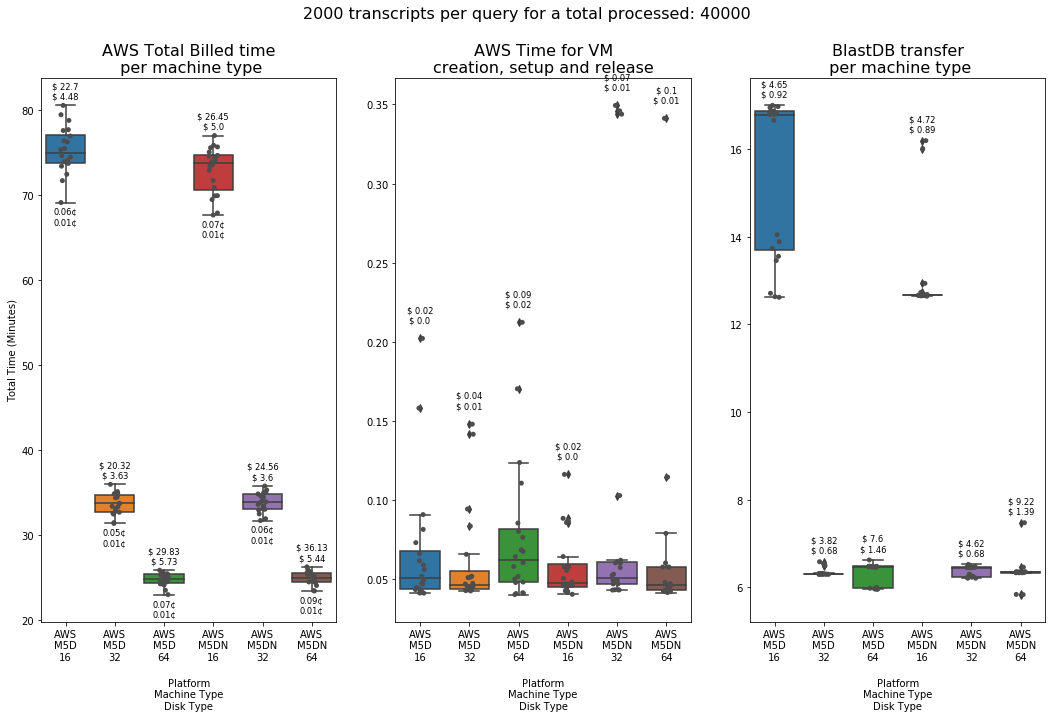

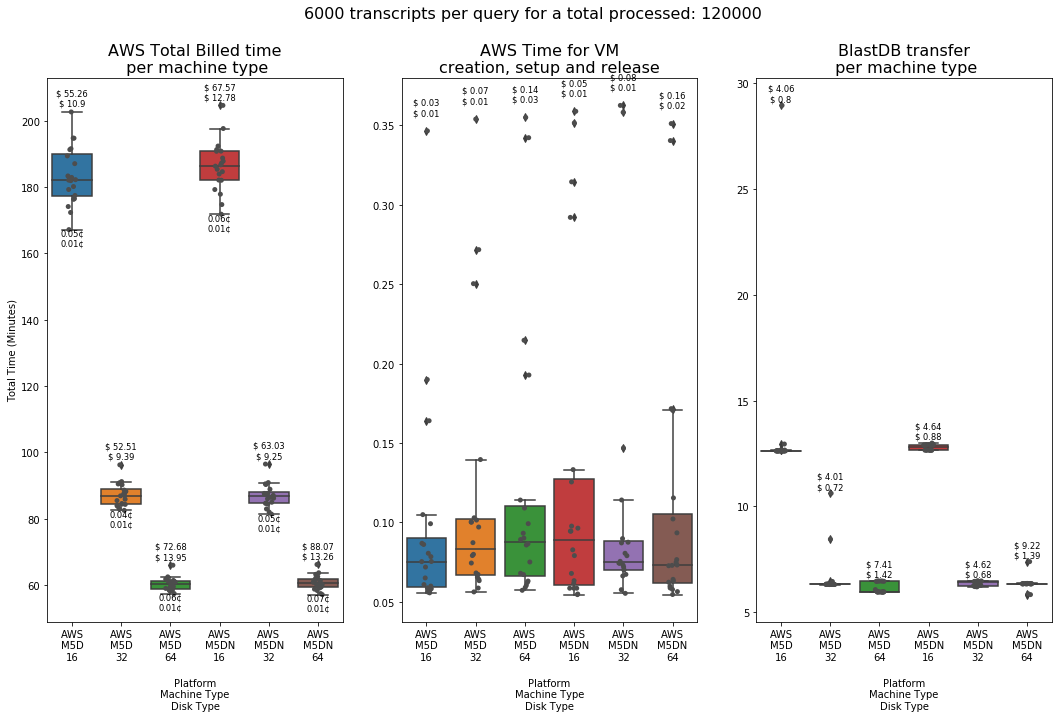

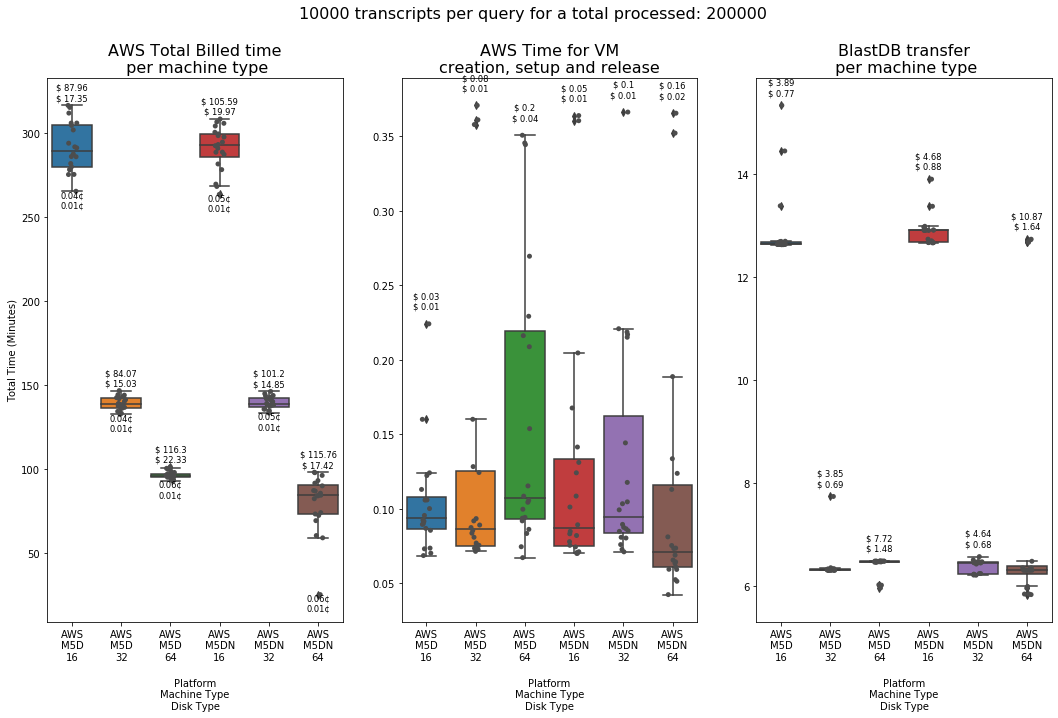

In [12]:
for q in QUERY_SIZES:
    df_total = jobs[q]['total']
    df_blast = jobs[q]['blast']
    df_creation = jobs[q]['creation']

    fig, axs = plt.subplots(figsize=(18,10), ncols=3)

    fig.suptitle(locale.format_string("%d", int(q), grouping=True)
                         + ' transcripts per query for a total processed: ' 
                         + locale.format_string("%d", int(q) * 20, grouping=True)
                 + '\n\n', fontsize=16)

    j=0

    top = []
    low = []
    billed = []
    cost = []
    for p in df_total['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_total[df_total['Platform'] == p]['Time'].max())
        low.append(df_total[df_total['Platform'] == p]['Time'].min())
        billed.append('$ {}\n$ {}'.format(
            round(df_total[df_total['Platform'] == p]['Time'].sum()/60 * EC2_PRICE[f[1]][int(f[2])], 2),
            round(df_total[df_total['Platform'] == p]['Time'].sum()/60 * SPOT_PRICE[f[1]][int(f[2])], 2)
        ))
        cost.append('{:.2f}¢\n{:.2f}¢'.format(
            df_total[df_total['Platform'] == p]['Time'].sum()/60 * EC2_PRICE[f[1]][int(f[2])] * 100/(int(q) * 20),
            df_total[df_total['Platform'] == p]['Time'].sum()/60 * SPOT_PRICE[f[1]][int(f[2])] * 100/(int(q) * 20)
        ))


    box_plot = sns.boxplot(x="Platform", y="Time", data=df_total, ax=axs[j])
    
    top_tick = 0.8
    low_tick = 2.6
    if q == 6000:
        top_tick += 1.0
        low_tick += 2.4
    elif q == 10000:
        top_tick += 2.2
        low_tick += 7.2

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + top_tick,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,low[xtick] - low_tick,cost[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_total, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("Total Time (Minutes)")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("AWS Total Billed time\n per machine type", fontsize=16)

    j = 1

    top = []
    billed = []
    for p in df_creation['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_creation[df_creation['Platform'] == p]['Time'].max())
        billed.append('$ {}\n$ {}'.format(
            round(df_creation[df_creation['Platform'] == p]['Time'].sum()/60 * EC2_PRICE[f[1]][int(f[2])], 2),
            round(df_creation[df_creation['Platform'] == p]['Time'].sum()/60 * SPOT_PRICE[f[1]][int(f[2])], 2)
        ))
        
    box_plot = sns.boxplot(x="Platform", y="Time", data=df_creation, ax=axs[j])

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + 0.01,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_creation, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("AWS Time for VM\ncreation, setup and release", fontsize=16)

    j = 2

    top = []
    billed = []
    for p in df_blast['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_blast[df_blast['Platform'] == p]['Time'].max())
        billed.append('$ {}\n$ {}'.format(
            round(df_blast[df_blast['Platform'] == p]['Time'].sum()/60 * EC2_PRICE[f[1]][int(f[2])], 2),
            round(df_blast[df_blast['Platform'] == p]['Time'].sum()/60 * SPOT_PRICE[f[1]][int(f[2])], 2)
        ))
        
    box_plot = sns.boxplot(x="Platform", y="Time", data=df_blast, ax=axs[j])

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + 0.2,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_blast, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("BlastDB transfer\n per machine type", fontsize=16)


## Processing 120k transcripts using query sizes of 2k, 6k and 10k

In [52]:
result_dir = os.path.join(RESULTS, DATASET, '120k')
if not os.path.exists(result_dir):
    os.mkdir(result_dir) 
os.chdir(result_dir)

In [19]:
bucket_list = !aws s3 ls | awk '{print $3}'
buckets = {}
for q in QUERY_SIZES:
    prefix = 'nopal-120k-' + str(q) + '-'
    suffix = None
    for l in bucket_list:
        if prefix in l:
            suffix = l.replace('nopal-120k-' + str(q) + '-','')
            break
    if suffix:
        buckets[q] = suffix    

for q in QUERY_SIZES:
    if q not in buckets:
        suffix = str(uuid.uuid4())
        inbucket = 'nopal-120k-' + str(q) + '-' + suffix
        outbucket = 'nopal-results-120k-' + str(q) + '-' + suffix
        buckets[q] = suffix 
        
        !aws s3 mb s3://{inbucket} --region {REGION}          
        !aws s3 mb s3://{outbucket} --region {REGION}
        if TAGFILE_S3:
            !aws s3api put-bucket-tagging --bucket {inbucket} --tagging file://{TAGFILE_S3} 
            !aws s3api put-bucket-tagging --bucket {outbucket} --tagging file://{TAGFILE_S3} 
        !aws s3 cp {q}/fasta/ s3://{inbucket}/ --recursive
        
for q in buckets:
    print('Query size: {0}\n\tin-bucket: nopal-120k-{0}-{1}\n\tout-bucket: nopal-results-120k-{0}-{1}'.format(q, buckets[q]))

Query size: 2000
	in-bucket: nopal-120k-2000-9f03d34f-ffac-4037-b5b8-da9fae170cd0
	out-bucket: nopal-results-120k-2000-9f03d34f-ffac-4037-b5b8-da9fae170cd0
Query size: 6000
	in-bucket: nopal-120k-6000-a9bf8e59-fe75-4b5a-9b99-97c305814f87
	out-bucket: nopal-results-120k-6000-a9bf8e59-fe75-4b5a-9b99-97c305814f87
Query size: 10000
	in-bucket: nopal-120k-10000-36858e5d-8b7c-4f69-a730-8ecf3514e287
	out-bucket: nopal-results-120k-10000-36858e5d-8b7c-4f69-a730-8ecf3514e287


In [54]:
os.chdir(result_dir)
m = 'm5dn'
c = {
        'name':'16xlarge',
        'CPUs': 64,
        'memory': 256 * 1000 - 5000
    }

bar_length = 20
jobs = {}
jobs_to_submit = 0
for q in QUERY_SIZES:
    jobs[q] = {}
    q_dir = os.path.join(result_dir, str(q))
    samples = [ f.replace('.fa', '') for ds, dr, files in os.walk(os.path.join(q_dir, 'fasta')) for f in files if f.endswith('.fa') ]
    
    instace_dir = os.path.join(q_dir, m, str(c['CPUs']))
    if not os.path.exists(instace_dir):
        os.makedirs(instace_dir)
    os.chdir(instace_dir)
    j = 1
    for s in samples:
        if os.path.exists('{}.id'.format(j)):
            jobs[q][s] = {'completed': True}
        else:
            jobs_to_submit += 1
            jobs[q][s] = {'completed': False}
        j += 1
print('{} jobs to be submitted'.format(jobs_to_submit))

0 jobs to be submitted


In [21]:
job_def_name = '{}_{}'.format(m,c['name'])
for q in QUERY_SIZES: 
    q_dir = os.path.join(result_dir, str(q))
    instace_dir = os.path.join(q_dir, m, str(c['CPUs']))
    os.chdir(instace_dir)
    inbucket = 'nopal-120k-' + str(q) + '-' + buckets[q]
    outbucket = 'nopal-results-120k-' + str(q) + '-' + buckets[q]
    
    samples = [ f.replace('.fa', '') for ds, dr, files in os.walk(os.path.join(q_dir, 'fasta')) for f in files if f.endswith('.fa') ]
    bar_length = len(samples)
    data = []
    submitted = 0
    i = 1
    for s in samples:
        if s in jobs[q] and not jobs[q][s]['completed']:
            submitted += 1
            job_name = '{}_{}'.format(s, job_def_name)             
            cmd = 'aws batch submit-job --job-name {} '.format(job_name)
            cmd += '--job-queue {}_queue '.format(job_def_name)
            cmd += '--job-definition {} '.format(job_def_name)
            cmd += '--container-overrides \'environment=['
            cmd += '{name=AWS_ACCESS_KEY_ID,value=' + access_key[0] + '},'
            cmd += '{name=AWS_SECRET_ACCESS_KEY,value=' + secret_access_key[0] + '},'
            cmd += '{name=SAMPLE,value=' + s + '},'
            cmd += '{name=INBUCKET,value=' + inbucket + '},'
            cmd += '{name=OUTBUCKET,value=' + outbucket + '}]\''

            output = !{cmd}
            job_id = json.loads(''.join(output))
            with open('{}.id'.format(i), 'w') as fout:
                fout.write(job_id['jobId'])
        progress = i * 100/bar_length
        text = "{0:25s} [{1}] {2:3.1f}% jobs submitted {3:3d}".format(job_name, "#" * i + "-" * (bar_length - i), progress, submitted)
        print(text, end='\r')  
        i += 1
    print()

2000_60_m5dn_16xlarge     [############################################################] 300.0% jobs submitted  60
6000_20_m5dn_16xlarge     [####################] 100.0% jobs submitted  20
10000_12_m5dn_16xlarge    [############--------] 60.0% jobs submitted  12


In [55]:
os.chdir(result_dir)
total = 0
done = 0
errors = []
total_no_completed = 0
for q in QUERY_SIZES:
    q_dir = os.path.join(result_dir, str(q))
    instace_dir = os.path.join(q_dir, m, str(c['CPUs']))
    job_def_name = '{}_{}'.format(m,c['name'])            
    os.chdir(instace_dir)  
    
    samples = [ f.replace('.fa', '') for ds, dr, files in os.walk(os.path.join(q_dir, 'fasta')) for f in files if f.endswith('.fa') ]
    bar_length = len(samples)
    
    completed = 0
    failed = 0
    no_completed = 0
    
    j = 1
    for s in samples:
        if os.path.exists('{}.id'.format(j)):
            mark_to_delete = False
            with open('{}.id'.format(j)) as fin:
                job_name = '{}_{}'.format(s, job_def_name) 
                job_id = fin.read()

                # The jobs ids loaded from the operation file are used to download the logs from AWS
                # The logs are check to see if they completed without any error. 
                total += 1 

                job_file = '{}_job.json.gz'.format(s)
                log_file = '{}_log.json.gz'.format(s)

                if os.path.exists(job_file):
                    try:
                        with gzip.GzipFile(job_file, 'r') as fin:  
                            job = json.loads(fin.read().decode('utf-8'))
                        with gzip.GzipFile(log_file, 'r') as fin:  
                            log = json.loads(fin.read().decode('utf-8'))
                            if aws_log_completed(log['events']):
                                completed += 1
                                done += 1
                                jobs[q][s][job_name] = {}
                                jobs[q][s][job_name]['job'] = job
                                jobs[q][s][job_name]['log'] = log
                            else:
                                failed += 1
                                mark_to_delete = True
                    except:
                        failed += 1
                        mark_to_delete = True


                else:
                    output = !aws batch describe-jobs --jobs {job_id}
                    l = json.loads(''.join(output))
                    if 'SUCCEEDED' == l['jobs'][0]['status']:
                        logStreamName = l['jobs'][0]['container']['logStreamName']
                        output = !aws logs get-log-events --log-group-name /aws/batch/job --log-stream-name {logStreamName}
                        log = json.loads(''.join(output))
                        if aws_log_completed(log['events']):
                            completed += 1
                            done += 1
                            jobs[q][s][job_name] = {}
                            jobs[q][s][job_name]['job'] = l
                            with gzip.GzipFile(job_file, 'w') as fout:
                                fout.write(json.dumps(l, indent=2).encode('utf-8'))
                            jobs[q][s][job_name]['log'] = log
                            with gzip.GzipFile(log_file, 'w') as fout:
                                fout.write(json.dumps(log, indent=2).encode('utf-8'))
                        else:
                            mark_to_delete = True
                            failed += 1

                    elif 'FAILED' == l['jobs'][0]['status']:
                        mark_to_delete = True
                        failed += 1
                    else:
                        no_completed += 1                        
            if mark_to_delete:
                if os.path.exists(job_file):
                    os.remove(job_file)
                if os.path.exists(log_file):
                    os.remove(log_file)
                os.remove('{}.id'.format(j))
        progress = j * 100/bar_length
        text = "{0:13s} [{1}] {2:3.1f}%\tQuery: {3} Completed {4:3d} Failed {5:3d} No completed {6:3d}".format(job_def_name, "#" * j + "-" * (bar_length - j), progress, q, completed, failed, no_completed)
        print(text, end='\r')
        j += 1
    print()
print('Total jobs {}/{}'.format(done, total))

m5dn_16xlarge [############################################################] 100.0%	Query: 2000 Completed  60 Failed   0 No completed   0
m5dn_16xlarge [####################] 100.0%	Query: 6000 Completed  20 Failed   0 No completed   0
m5dn_16xlarge [############] 100.0%	Query: 10000 Completed  12 Failed   0 No completed   0
Total jobs 92/92


In [56]:
boxdata_total = []
for q in QUERY_SIZES:
    q_dir = os.path.join(result_dir, str(q))    
    data = []
    job_def_name = '{}_{}'.format(m,c['name'])
    platform = 'AWS\n{}\n{}'.format(m.upper(), c['CPUs'])
    
    samples = [ f.replace('.fa', '') for ds, dr, files in os.walk(os.path.join(q_dir, 'fasta')) for f in files if f.endswith('.fa') ]
    bar_length = len(samples)
    
    j = 1
    for s in samples:
        progress = j * 100/20
        text = "{0:13s} [{1}] {2:.1f}%\tQuery: {3}".format(job_def_name, "#" * j + "-" * (bar_length - j), progress, q)
        print(text, end='\r')
        
        job_name = '{}_{}'.format(s, job_def_name) 
        if job_name in jobs[q][s]:
            if 'job' in jobs[q][s][job_name]:
                st = jobs[q][s][job_name]['job']['jobs'][0]['startedAt']
                e = jobs[q][s][job_name]['job']['jobs'][0]['stoppedAt']                        
                total = (e-st)/(1000*60)
                db, cwl = aws_log_times(jobs[q][s][job_name]['log']['events'])
                data.append([s, total, db, cwl])
                boxdata_total.append([total, q])
        j += 1
    jobs[q]['aws'] = pandas.DataFrame(data, columns=['id', 'AWS', 'BlastDB', 'CWL'])        
    print()
    os.chdir(q_dir)
jobs['total'] = pandas.DataFrame(boxdata_total, columns=['Time', 'Query'])
jobs['total'].to_csv(os.path.join(result_dir,'aws_total_120k.tsv'), sep='\t', index=None)  

m5dn_16xlarge [############################################################] 300.0%	Query: 2000
m5dn_16xlarge [####################] 100.0%	Query: 6000
m5dn_16xlarge [############] 60.0%	Query: 10000


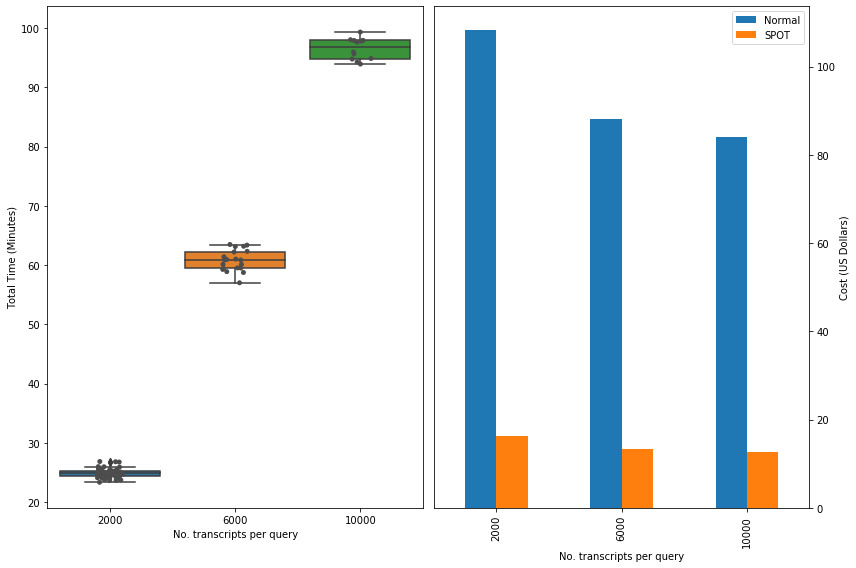

In [59]:
data = []
for p in jobs['total']['Query'].unique():
    data.append([jobs['total'][jobs['total']['Query'] == p]['Time'].sum()/60 * EC2_PRICE['m5dn'][64],
                jobs['total'][jobs['total']['Query'] == p]['Time'].sum()/60 * SPOT_PRICE['m5dn'][64],
                 p])
cost = pandas.DataFrame(data, columns=['Normal', 'SPOT', 'Query'])
cost.to_csv(os.path.join(result_dir,'aws_cost_120k.tsv'), sep='\t', index=None)  

fig, ax = plt.subplots(figsize=(12,8), ncols=2)

box_plot = sns.boxplot(x="Query", y="Time", data=jobs['total'], ax=ax[0])
sns.stripplot(x="Query", y="Time", data=jobs['total'], jitter=True, color=".3", ax=ax[0])

ax[0].set_ylabel("Total Time (Minutes)")
ax[0].set_xlabel("No. transcripts per query")

cost.plot(x="Query", kind="bar", ax=ax[1])
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel("Cost (US Dollars)")
ax[1].set_xlabel("No. transcripts per query")

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles, labels)
fig.tight_layout()

### Deleting all resources created

In [50]:
for m in MACHINE_TYPES:
    for c in CPUs:
        job_def_name = '{}_{}'.format(m,c['name'])
        print('Deregistering job definition {}'.format(job_def_name))    
        !aws batch deregister-job-definition --job-definition {job_def_name}

        queue_name = '{}_{}_queue'.format(m,c['name'])
        print('Disabling queue {}'.format(queue_name)) 
        output = !aws batch update-job-queue --job-queue {queue_name} --state DISABLED
        if not ''.join(output).endswith('queue does not exist'):
            while True:
                try:
                    time.sleep(15)
                    output = !aws batch describe-job-queues --job-queues {queue_name}
                    queue = json.loads(''.join(output))
                    if 'jobQueues' in queue and len(queue['jobQueues']) == 1 and queue['jobQueues'][0]['state'] == 'DISABLED' and queue['jobQueues'][0]['status'] == 'VALID':
                        queue = queue['jobQueues'][0]
                        if queue['state'] == 'DISABLED':
                            print('Deleting queue definition {}'.format(queue_name)) 
                            !aws batch delete-job-queue --job-queue {queue_name}
                            break
                except:
                    print('Error: {}'.format(output))
                    break

        comp_env_name = '{}_{}_managed'.format(m,c['name'])
        print('Disabling compute environment {}'.format(comp_env_name)) 
        output = !aws batch update-compute-environment --compute-environment {comp_env_name} --state DISABLED
        if not ''.join(output).endswith('does not exist'):
            while True:
                try:
                    time.sleep(15)
                    output = !aws batch describe-compute-environments --compute-environments {comp_env_name}
                    comp_env = json.loads(''.join(output))                    
                    if 'computeEnvironments' in comp_env and len(comp_env['computeEnvironments']) == 1:
                        comp_env = comp_env['computeEnvironments'][0]
                        output = !aws batch describe-job-queues --job-queues {queue_name}
                        queue = json.loads(''.join(output))
                        if 'jobQueues' in queue and len(queue['jobQueues']) == 0 and comp_env['state'] == 'DISABLED' and comp_env['status'] == 'VALID':
                            print('Deleting compute environment {}'.format(comp_env_name))
                            !aws batch delete-compute-environment --compute-environment {comp_env_name}
                            break
                except:
                    print('Error: {}'.format(output))
                    break


Deregistering job definition m5d_4xlarge
Disabling queue m5d_4xlarge_queue
Deleting queue definition m5d_4xlarge_queue
Disabling compute environment m5d_4xlarge_managed
Deleting compute environment m5d_4xlarge_managed
Deregistering job definition m5d_8xlarge
Disabling queue m5d_8xlarge_queue
Deleting queue definition m5d_8xlarge_queue
Disabling compute environment m5d_8xlarge_managed
Deleting compute environment m5d_8xlarge_managed
Deregistering job definition m5d_16xlarge
Disabling queue m5d_16xlarge_queue
Deleting queue definition m5d_16xlarge_queue
Disabling compute environment m5d_16xlarge_managed
Deleting compute environment m5d_16xlarge_managed
Deregistering job definition m5dn_4xlarge
Disabling queue m5dn_4xlarge_queue
Deleting queue definition m5dn_4xlarge_queue
Disabling compute environment m5dn_4xlarge_managed
Deleting compute environment m5dn_4xlarge_managed
Deregistering job definition m5dn_8xlarge
Disabling queue m5dn_8xlarge_queue
Deleting queue definition m5dn_8xlarge_qu